In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.pyplot import plot, draw, show
from scipy.linalg import lu
import scipy.linalg as la
import random
import simpy
import math
import seaborn as sns

In [54]:
plt.rcParams['figure.figsize'] = [15, 5]

def plotpretify(ax, maxx, minx=0, miny=None, maxy=None,
                Grid=True, LB=True, LL=True):
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        top=False,
        labelbottom=False,
        left=False,
        right=False,
        labelleft=False)
#     ax.grid(True)
    
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

sns.set()

In [6]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)  # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name, index=index)
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name, index=index, size=size)
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name, index=str(index or '?'))

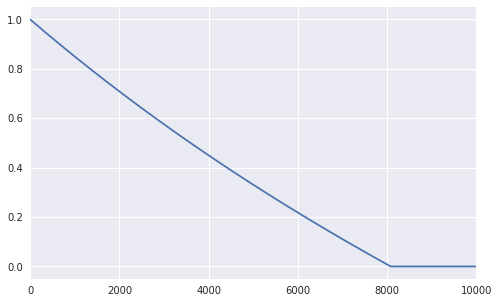

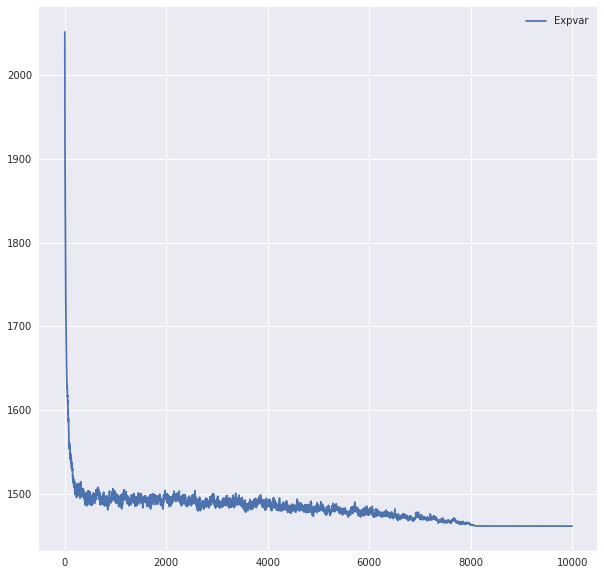

1461.6448843642916


[None]

In [48]:
def plot(coordList):
    plt.rcParams['figure.figsize'] = [10, 10]
    sns.set()
    sns.set_style("dark")
    fig = plt.figure()
    ax = plt.subplot(111)
    colors = list(range(len(coordList)))
    ax.scatter(coordList[:, 0], coordList[:, 1], c=colors, cmap='Dark2')
    circle1 = plt.Circle((0, 0), radius, alpha=0.2, color="olive")
    ax.add_artist(circle1)
    plotpretify(
        ax,
        1.1,
        minx=-1.1,
        miny=-1.1,
        maxy=1.1,
        Grid=False,
        LL=False,
        LB=False)


def getScheme_data(iters, plot="No", scheme="Sigmoid"):

    answer = []

    if scheme == "Sigmoid":
        linspace = np.linspace(0, 9, iters)
        for x in linspace:
            answer.append(0.5 +
                          math.erf((math.sqrt(math.pi) / 2) * (x - 2)) * -0.5)
    elif scheme == "Exp":
        for x in range(iters):
            answer.append(np.exp(-x / iters))
    elif scheme == "Expvar":
        for x in range(iters):
            answer.append(
                max(
                    np.exp(-x / iters) - ((1.5 * x) / iterations) * (1 / math.e),
                    0))
    elif scheme == "Hillclimb":
        for x in range(iters):
            answer.append(0)
    elif scheme == "Binary":
        for x in range(iters):
            if x < iters / 2:
                answer.append(1)
            else:
                answer.append(0)

    if plot == "Yes":
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        ax.plot(answer, label="Acceptance chance")
        plotpretify(ax, iters)
        plt.show()
    return np.array(answer)


def incircle(crds, r=1):
    return np.power(crds[0], 2) + np.power(crds[1], 2) < r


def spawn(r=1):
    x = random.uniform(-r, r)
    limits = [-np.sqrt(r**2 - x**2), np.sqrt(r**2 - x**2)]
    y = random.uniform(limits[0], limits[1])
    return [x, y]

# Good score when somewhere < 2
def checkScore(coord):
    totalDist = 0
    for i in range(len(coord)):
        for j in range(i, len(coord)):
            if i != j:
                totalDist += 1 / abs(
                    math.hypot(coord[j][0] - coord[i][0],
                               coord[j][1] - coord[i][1]))
    return totalDist

def move(k, coord, temp, rate):
    F = np.array([0.0, 0.0])
    velocity = np.zeros(2, float)
    for l in coord:
        if any(l != k):
            r = np.array(k) - np.array(l)
            F1 = (r / (np.linalg.norm(r)**3) * rate)
            F += F1
    newPoint = k + F
    xr = random.uniform(-1, 1) * (1 / 50)
    yr = random.uniform(-1, 1) * (1 / 50)
#     print(f"xr = {xr}")
    newPoint += [xr, yr]
    if not incircle(newPoint, radius):
        newPoint = newPoint / la.norm(newPoint)
    return newPoint, F

def submove(k, i, coord, temp, rate, score):
    global coordListList
    cT, favo = move(k, coord, temp, rate)
    coordTemp = np.copy(coord)
    coordTemp[i] = cT
    coordListList.append(coordTemp)
#     print(f"score = {score}")
#     print(f"scoretemp = {checkScore(coordTemp)}")
#     print("-----")
    if score > checkScore(coordTemp):
        return np.array(coordTemp), favo
    elif temp > random.random():
        return np.array(coordTemp), favo
    else:
        return coord, favo


def changeCoord(coord, temp, rate):
    score = checkScore(coord)
    fav = []
    for i, k in enumerate(coord):
        coord, favo = submove(k, i, coord, temp, rate, score)
        fav.append(favo)
    return coord


def start_sim(radius,
              pointsNum,
              iterations,
              rate,
              scheme,
              markovChain,
              plotScheme="No"):
    coordList = []
    global coordListList
    schemeData = np.repeat(
        getScheme_data(iterations, plot=plotScheme, scheme=scheme),
        markovChain)
    iterations = iterations * markovChain

    for i in range(pointsNum):
        coordList.append(spawn(radius))
    # 2 points:
#     coordList = [[-1,0], [-0.5,0]]
    # coordList = [[-1,0], [-0.5,0.3]]
#     coordList = [[0.2,0.2], [-0.5,0.3]]

    # 3 points:
#     coordList = [[0.2,0.2], [-0.5,0.3], [-0.1, -0.2]]
    coordList = np.array(coordList)

#     coordListList = [coordList]
    coordListList = []
    coordListList.append(coordList)
    checklist = []
    for i in log_progress(range(iterations), every=1):
        temp = schemeData[i]
        coordList = changeCoord(coordList, temp, rate)
        coordListList.append(coordList)
        checklist.append(checkScore(coordList))

    return coordList, coordListList, checklist

coordListList = []

radius = 1
pointsNum = 40
iterations = 10000
rate = math.pow(10, -4)
schemes = ["Sigmoid", "Exp", "Expvar", "Hillclimb"]
schemes = ["Expvar"]
# schemes = ["Expvar", "Sigmoid"]
# schemes = ["Hillclimb", "Expvar", "Expvar", "Exp"]
scheme = "Sigmoid"
checks = []
coordListListList = []

for scheme in schemes:
    coordList, coordListList, checklist = start_sim(
        radius, pointsNum, iterations, rate, scheme, 1, plotScheme="Yes")
    checks.append(checklist)
    coordListListList.append(coordListList)

[plt.plot(check, label=schemes[i]) for i, check in enumerate(checks)]
plt.legend()
plt.show()
[print(check[-1]) for check in checks]

In [56]:
def plot(coordList):
    plt.rcParams['figure.figsize'] = [10, 10]
    sns.set()
    sns.set_style("white")
    fig = plt.figure()
    ax = plt.subplot(111)
    colors = list(range(len(coordList)))
    ax.scatter(coordList[:, 0], coordList[:, 1], c=colors, cmap='Dark2')
    circle1 = plt.Circle((0, 0), radius, alpha=0.2, color="olive")
    ax.add_artist(circle1)
    plotpretify(
        ax,
        1.1,
        minx=-1.1,
        miny=-1.1,
        maxy=1.1,
        Grid=False,
        LL=False,
        LB=False)

Expvar


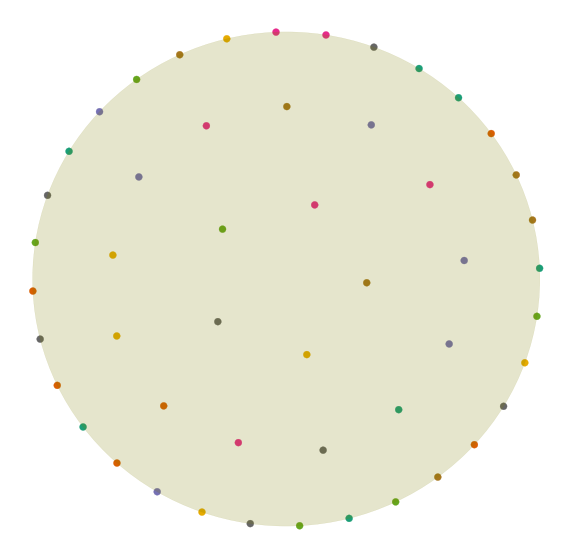

In [57]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

for j in range(len(coordListListList)):
    print(schemes[j])
    def showPlot(i=0):
        plot(coordListListList[j][i])

    # for cll in coordListListList:
#     y = interactive(showPlot, i=(0, len(coordListListList[j]) - 1, 1))
#     y = interactive(showPlot, i=range(len(coordListListList[j])))
    plot(coordListListList[j][-1])
#     display(y)